<a href="https://colab.research.google.com/github/msalvati1997/energy_meter/blob/main/Detect_energy_of_a_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [83]:
dataset = pd.read_csv('https://raw.githubusercontent.com/msalvati1997/energy_meter/main/results.csv?token=GHSAT0AAAAAABYLICDCSLD5IX7ZXKEJEGPIY3M34KA', parse_dates=['time'])

In [84]:
dataset

,Unnamed: 0,time,power
0,0,2022-11-10 09:18:54.338000+00:00,0.291863
1,1,2022-11-10 09:18:54.840000+00:00,2.400581
2,2,2022-11-10 09:18:55.343000+00:00,6.506085
3,3,2022-11-10 09:18:55.849000+00:00,3.969375
4,4,2022-11-10 09:18:56.352000+00:00,1.896853
...,...,...,...
3005,3005,2022-11-10 09:44:21.312000+00:00,0.000666
3006,3006,2022-11-10 09:44:21.816000+00:00,0.000733
3007,3007,2022-11-10 09:44:22.319000+00:00,0.000934
3008,3008,2022-11-10 09:44:22.823000+00:00,0.005040


In [85]:
dataset = dataset.sort_values(by=['time']).reset_index(drop=True).to_numpy()  # Sort and convert to numpy array

In [86]:
dataset

array([[0, Timestamp('2022-11-10 09:18:54.338000+0000', tz='UTC'),
        0.2918625369115011],
       [1, Timestamp('2022-11-10 09:18:54.840000+0000', tz='UTC'),
        2.4005811650648887],
       [2, Timestamp('2022-11-10 09:18:55.343000+0000', tz='UTC'),
        6.506085005904202],
       ...,
       [3007, Timestamp('2022-11-10 09:44:22.319000+0000', tz='UTC'),
        0.0009337237759461],
       [3008, Timestamp('2022-11-10 09:44:22.823000+0000', tz='UTC'),
        0.0050397871040655],
       [3009, Timestamp('2022-11-10 09:44:23.326000+0000', tz='UTC'),
        0.0009401026747766]], dtype=object)

In [87]:
# Split into 2 arrays
values = [float(i[2]) for i in dataset]  # Flow values, in float
values = np.array(values)

dates = [i[1].to_pydatetime() for i in dataset]
dates = np.array(dates)

In [88]:
flow = np.diff(values).tolist()
time = np.diff(dates).tolist()

In [89]:
time= [float(i.total_seconds()) for i in time]  # Flow values, in float

In [90]:
slopes = np.divide(flow, time) # (flow[i+1] - flow[i]) / (time[i+1] - time[i])
slopes = np.insert(slopes, 0, 0, axis=0) # Since we "lose" the first index, this one is 0, just for alignments

In [91]:
# ROLLING WINDOW
size = len(dataset)
rolling_window = []
rolling_window_indexes = []
RW = []
RWi = []
window_size = 240  # Seconds


# create the rollings windows
for line in range(size):
    limit_stamp = dates[line] + datetime.timedelta(seconds=window_size)
    for subline in range(line, size, 1):
        if dates[subline] <= limit_stamp:

            rolling_window.append(slopes[subline])  # Values of the slopes
            rolling_window_indexes.append(subline)  # Indexes of the respective values

        else:

            RW.append(rolling_window)
            if line != size: # To prevent clearing the last rolling window
                rolling_window = []

            RWi.append(rolling_window_indexes)
            if line != size:
                rolling_window_indexes = []

            break
else:
    # To get the last rolling window since it breaks before append
    RW.append(rolling_window)
    RWi.append(rolling_window_indexes)

In [113]:
t = 0.13 # Threshold
peaks = []
  
for index, rollWin in enumerate(RW):
    if rollWin[0] > t: # If the first value is greater of threshold
        top = rollWin[0] # Sets as a possible peak
        bottom = np.min(rollWin) # Finds the minimum of the peak

        if bottom < -t: # If less than the negative threshold
            bottomIndex = int(np.argmin(rollWin)) # Find it's index

            for peak in range(0, bottomIndex, 1): # Appends all points between the first index of the rolling window until the bottomIndex
                peaks.append(RWi[index][peak]) 


In [114]:
for i in peaks:
  print(dates[i], values[i])

2022-11-10 09:18:54.840000+00:00 2.4005811650648887
2022-11-10 09:18:55.343000+00:00 6.506085005904202
2022-11-10 09:18:55.343000+00:00 6.506085005904202


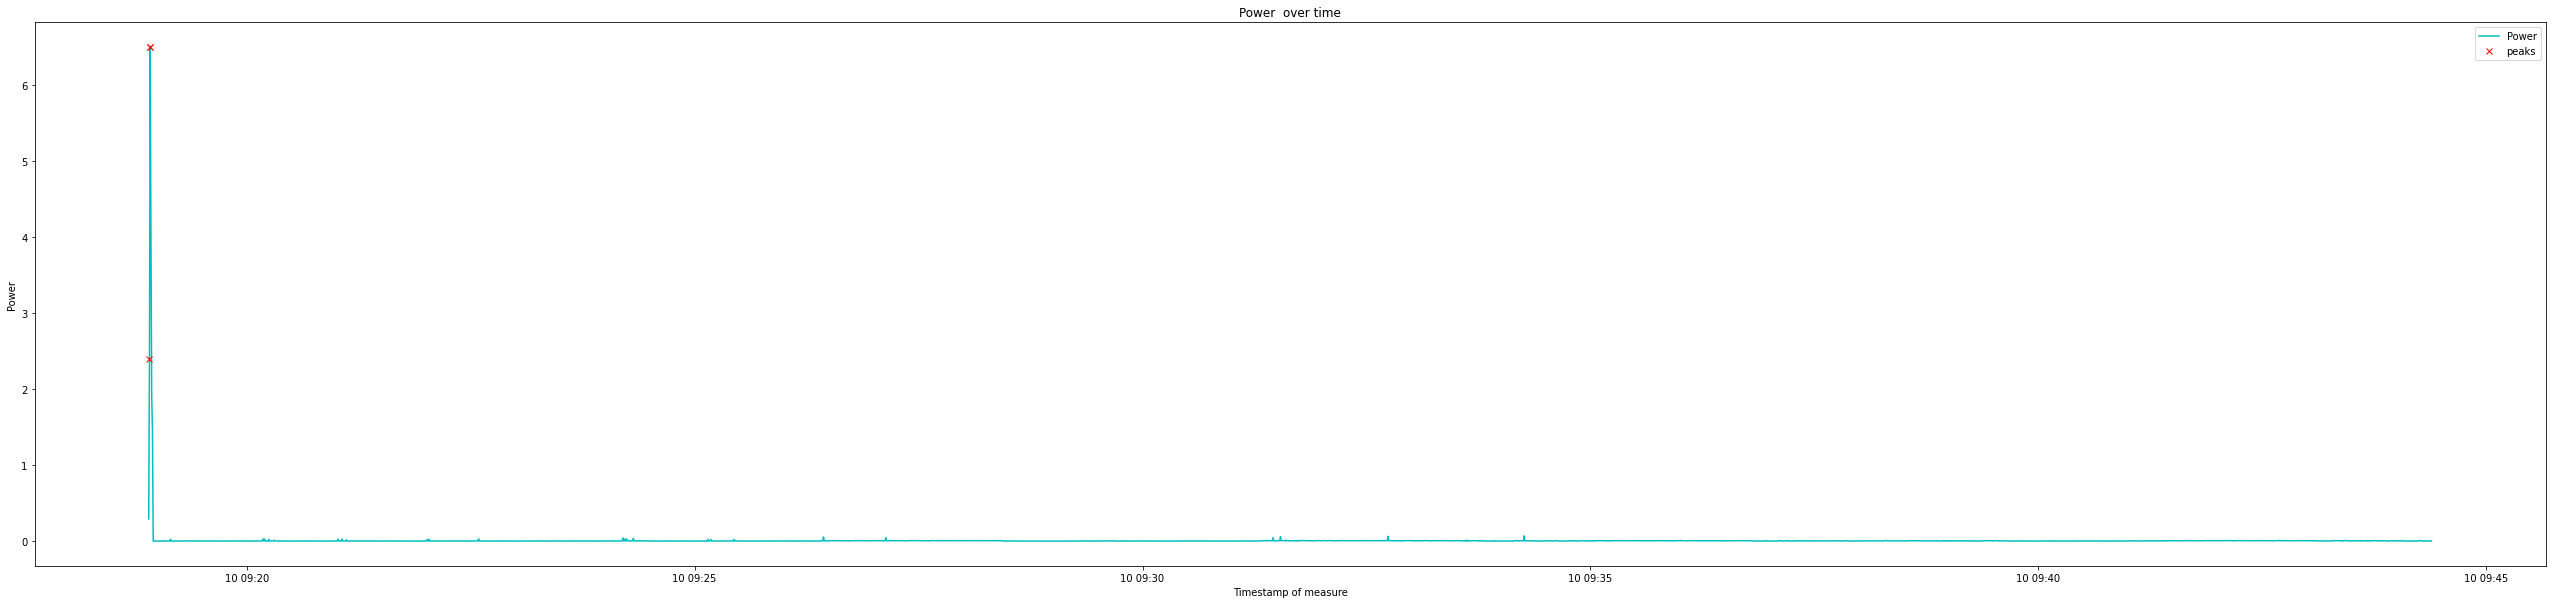

In [115]:
from matplotlib.dates import DateFormatter

date_form = DateFormatter("%H:%M:%S")  # Xlabel for the plot_values

def plot_values(dates=None, values=None, dates_indexes=None, values_indexes=None):
    """
    This function is to plot the water flow accordingly to the timestamps of measuring
    :param dates: array-like of pydatetimes
    :param values: array-like of floats
    :param dates_indexes: peak filtered dates
    :param values_indexes: peak filtered values
    :return:
    """

    global dataset

    plt.figure(figsize=(45, 10))

    plt.plot(dates, values, 'c', label="Power")  # Plotting of all values
    plt.plot(dates_indexes, values_indexes, "xr", label="peaks")  # Plotting of all peaks

    plt.xlabel("Timestamp of measure")
    plt.ylabel("Power")
    plt.legend()
    plt.title("Power  over time")
    plt.show()

# PLOTTING
plot_values(dates, values, dates[peaks], values[peaks]) # The real dataset and the peaks

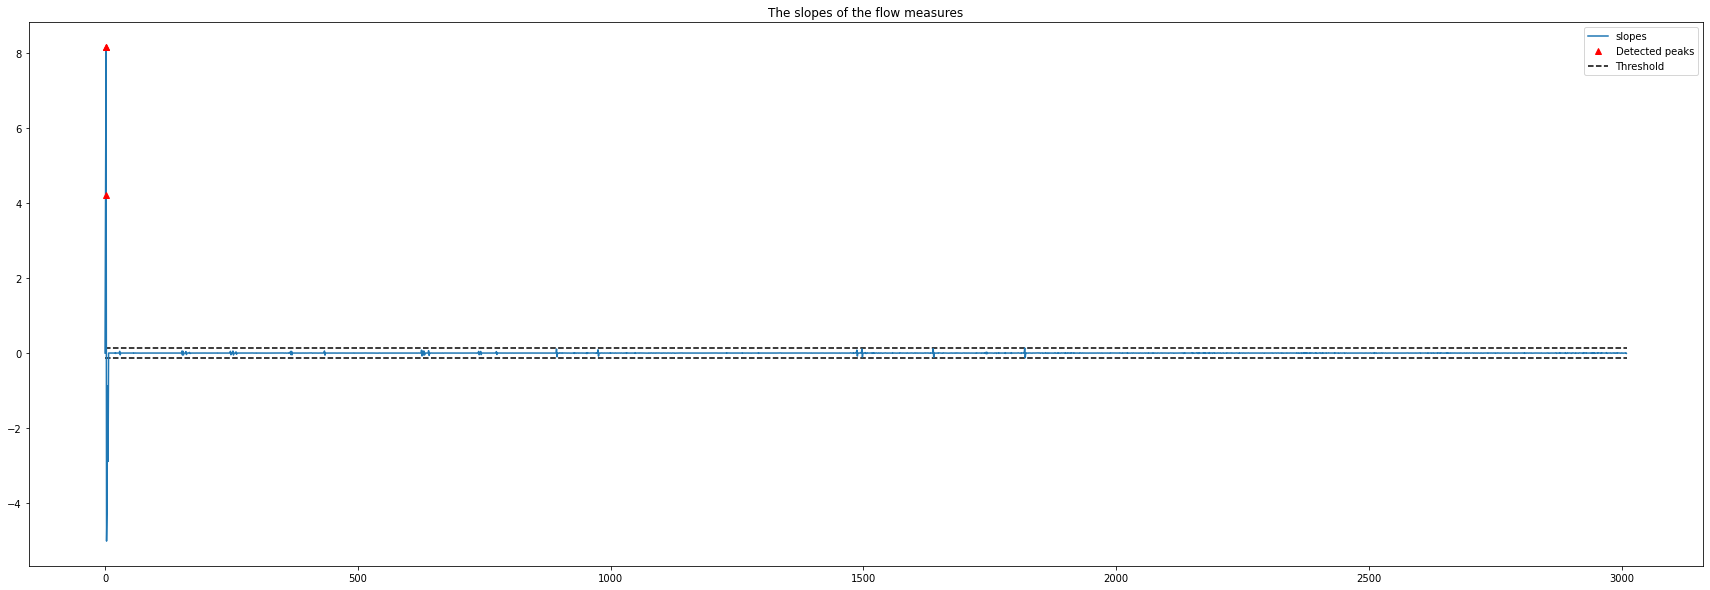

In [116]:
def plot_slopes():
    """
        This function is to plot the slope that the water flow creates
    """
    plt.figure(figsize=(30, 10))

    plt.plot(slopes, label="slopes")
    plt.hlines(t, 0, len(values), linestyles="dashed", label="Threshold")
    plt.hlines(-t, 0, len(values), linestyles="dashed")
    plt.plot(peaks, slopes[peaks], "^r", label="Detected peaks")

    plt.legend()
    plt.title("The slopes of the flow measures")
    plt.show()

plot_slopes() # The slopes and the peaks
